# **Breast Cancer Prediction Pipeline 3**

This notebook implements the main pipeline for breast cancer classification using RNA-Seq data. It includes data loading and preprocessing, statistical feature selection (ANOVA F-test), dimensionality reduction (PCA), and classification using a Random Forest model.

### **Setup and Configuration**

This step sets up the required libraries and defines the folder structure used in this notebook. The data is organized into four main folders under `data/`:
- `raw/`: Raw downloaded files (e.g., GTEx `.gct`, GDC `.tsv`).
- `initial/`: Processed raw files (e.g., merged and transposed).
- `interim/`: Feature-selected or partially transformed files.
- `processed/`: Final model-ready inputs (e.g., PCA-reduced features).

In [1]:
# Import required libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
import shutil
import pickle
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, permutation_test_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.metrics import roc_curve, auc

In [2]:
# Define data folder structure
DATA_DIR = "data"

INITIAL_DIR = os.path.join(DATA_DIR, "initial")
INTERIM_DIR = os.path.join(DATA_DIR, "interim")

PIPLINE_03_DIR = "pipeline_03"
MODELS_DIR = os.path.join(PIPLINE_03_DIR, "models")
REPORTS_DIR = os.path.join(PIPLINE_03_DIR, "reports")

In [3]:
# Create directories if they don't exist
os.makedirs(PIPLINE_03_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(REPORTS_DIR, exist_ok=True)

---

### **Step 1: Statistical Feature Selection using ANOVA F-test**

This step applies a univariate statistical method — the ANOVA F-test — to select the most informative gene features for classification. It is a standard approach for high-dimensional data such as RNA-Seq, where the number of features (genes) far exceeds the number of samples.

This step includes:
1. **Loads**:
   - The combined feature matrix from `data/interim/preprocessed_data_features.csv`
   - The label vector from `data/interim/preprocessed_data_labels.csv`
2. Applies **ANOVA F-test** using `SelectKBest` from `scikit-learn` to select the top 1000 gene features that show the most variation between the cancer and non-cancer classes.
3. Saves the reduced feature matrix for downstream use.

##### Output:
- `selected_features.csv` (in `data/interim/`): A reduced feature matrix with shape (samples × 1000)

This step dramatically reduces the feature space from ~60,000 genes to 1000, making subsequent modeling steps more efficient and less prone to overfitting.


In [4]:
import pandas as pd
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif

def remove_constant_features(features):
    """Remove constant features from the dataset."""
    selector = VarianceThreshold()
    return selector.fit_transform(features), selector.get_support(indices=True)

def statistical_feature_selection(features_file, labels_file, output_file, k=1000):
    # Load preprocessed features and labels
    features = pd.read_csv(features_file)
    labels = pd.read_csv(labels_file)

    # Remove constant features
    features_no_constants, selected_indices = remove_constant_features(features)
    feature_names = features.columns[selected_indices]

    # Perform feature selection
    selector = SelectKBest(f_classif, k=k)
    selected_features = selector.fit_transform(features_no_constants, labels['label'])

    # Get selected feature names
    feature_names = feature_names[selector.get_support()]
    selected_features_df = pd.DataFrame(selected_features, columns=feature_names)
    
    # Save the selected features to the output file
    selected_features_df.to_csv(output_file, index=False)

    print("Statistical Feature Selection Complete")
    print("Shape of selected features:", selected_features_df.shape)
    
    return feature_names

In [5]:
features_file = os.path.join(INTERIM_DIR, 'training_data_features.csv')
labels_file = os.path.join(INTERIM_DIR,'training_data_labels.csv')

output_file = os.path.join(PIPLINE_03_DIR, 'training_data_selected_features.csv')

selected_feature_names = statistical_feature_selection(features_file, labels_file, output_file)

with open(os.path.join(PIPLINE_03_DIR,'selected_feature_names.pkl'), 'wb') as f:
    pickle.dump(selected_feature_names, f)


Statistical Feature Selection Complete
Shape of selected features: (2000, 1000)


In [6]:
label_file_in_interim = os.path.join(INTERIM_DIR, 'training_data_labels.csv')
label_file_in_pipeline = os.path.join(PIPLINE_03_DIR, 'training_data_labels.csv')

# Copy the label file into the "processed" folder 
shutil.copyfile(label_file_in_interim, label_file_in_pipeline)

'pipeline_03/training_data_labels.csv'

---

### **Step 2: Dimensionality Reduction using PCA**

After statistical feature selection, this step applies Principal Component Analysis (PCA) to further reduce the dimensionality of the data. PCA projects the 1000 selected gene features into a lower-dimensional space while preserving as much variance as possible.

This step includes:
1. **Loads**:
   - The 1000-gene feature matrix from `data/interim/selected_features.csv`
2. Applies **PCA** to reduce the feature space to 50 principal components.
3. Transforms the dataset into the reduced space and saves it.

##### Output:
- `pca_reduced_features.csv` (in `data/processed/`): A feature matrix with shape (samples × 50), ready for training classifiers.

PCA helps compress the dataset, reduce noise, and improve the stability and performance of machine learning models in high-dimensional settings like genomics.


In [7]:
def dimensionality_reduction(selected_features_file, output_file, n_components=50):
    # Load selected features
    selected_features = pd.read_csv(selected_features_file)

    # Perform PCA
    pca = PCA(n_components=n_components)
    reduced_features = pca.fit_transform(selected_features)

    # Create a DataFrame with reduced features
    reduced_features_df = pd.DataFrame(reduced_features, columns=[f'PC{i+1}' for i in range(n_components)])
    
    # Save the reduced features to the output file
    reduced_features_df.to_csv(output_file, index=False)

    print("Dimensionality Reduction Complete")
    print("Shape of reduced features:", reduced_features_df.shape)

    return pca

In [8]:
n_components = 50
selected_features_file = os.path.join(PIPLINE_03_DIR, 'training_data_selected_features.csv')
output_file = os.path.join(PIPLINE_03_DIR, 'training_data_reduced_features.csv')

pca_transformer_50 = dimensionality_reduction(selected_features_file, output_file, n_components)

with open(os.path.join(PIPLINE_03_DIR,'pca_transformer_50.pkl'), 'wb') as f:
    pickle.dump(pca_transformer_50, f)

Dimensionality Reduction Complete
Shape of reduced features: (2000, 50)


---

### **Step 3: Classification with Random Forest and Evaluation**

This step trains a machine learning classifier to distinguish between cancer and non-cancer samples using the PCA-reduced feature matrix.

A **Random Forest** classifier is used due to its robustness, interpretability, and suitability for high-dimensional biological data. Evaluation is done using **5-fold Stratified Cross-Validation** to ensure balanced class representation in each fold.

This step includes:
1. **Loads**:
   - PCA-reduced feature matrix from `data/processed/pca_reduced_features.csv`
   - Corresponding labels from `data/interim/preprocessed_data_labels.csv`
2. Performs **5-fold Stratified Cross-Validation**, training and testing the Random Forest model on different splits.
3. Computes and stores key performance metrics:
   - Accuracy
   - Precision
   - Recall
   - F1-score

##### Output:
- A printed performance summary for each fold.
- Optionally: confusion matrices and average metric summaries.

This step provides a robust estimate of the model’s generalization performance on unseen data.


In [9]:
def dual_print(file_path, *args, **kwargs):
    mode = kwargs.get('mode', 'a')
    message = " ".join(map(str, args))
    print(message)
    with open(file_path, mode) as file:
        file.write(message + '\n')

In [10]:
def cross_validate_model(features_file, labels_file, model_file_prefix, report_file_prefix, num_splits=5, perm=False, n_permutations=500):
    from statistics import stdev
    from math import sqrt

    report_file = report_file_prefix + '_report.txt'

    # Load data
    X = pd.read_csv(features_file)
    y = pd.read_csv(labels_file).values.ravel()

    # Stratified K-Fold Cross-Validation
    skf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=45)
    accuracies, precisions, recalls, f1_scores , aucs, specificities = [], [], [], [], [], []
    confusion_matrices = []

    fig_cm = plt.figure(figsize=(12, 12), dpi=300, constrained_layout=False)
    gs = gridspec.GridSpec(5, 1, figure=fig_cm, wspace=3, hspace=0.5)

    model_number = 0
    for train_index, test_index in skf.split(X, y):
        
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model_number += 1
        
        model = RandomForestClassifier(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)

        # Save the model
        model_file = model_file_prefix + '_model' + str(model_number) + '.pkl'
        with open(model_file, 'wb') as f:
            pickle.dump(model, f)
            
        y_pred = model.predict(X_test)

        cur_acc = accuracy_score(y_test, y_pred)
        accuracies.append(cur_acc)

        cur_pre = precision_score(y_test, y_pred, zero_division=1)
        precisions.append(cur_pre)

        cur_rec = recall_score(y_test, y_pred, zero_division=1)
        recalls.append(cur_rec)

        cur_f1 = f1_score(y_test, y_pred, zero_division=1)
        f1_scores.append(cur_f1)

        # AUC (Area Under Curve)
        y_proba = model.predict_proba(X_test)[:, 1]
        cur_auc = roc_auc_score(y_test, y_proba)
        aucs.append(cur_auc)

        # Specificity = TN / (TN + FP)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        cur_spe = tn / (tn + fp)
        specificities.append(cur_spe)

        # Save confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        confusion_matrices.append(cm)

        # Draw confusion matrices in one plot
        i = model_number - 1
        # if i < 3:
        #     ax = plt.subplot(gs[0, 2 * i:2 * i + 2])
        # else:
        #     ax = plt.subplot(gs[1, 2 * i - 5:2 * i + 2 - 5])

        ax = plt.subplot(gs[i, 0])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(ax=ax, cmap='Blues', colorbar=False)

        ax.set_title(f'Fold {model_number}', fontsize=6, fontweight="bold")
        ax.set_xlabel('Prediction', fontsize = 5, fontweight="bold")
        ax.set_ylabel('Actual', fontsize = 5, fontweight="bold")
        ax.set_xticklabels(['Benign', 'Cancer'], fontsize=5, rotation=0)
        ax.set_yticklabels(['Benign', 'Cancer'], fontsize=5, rotation=90)
    
        # if hasattr(disp, "text_") and disp.text_ is not None:
        #     for text in disp.text_.ravel():
        #         text.set_fontsize(6)

    # Compute averages
    avg_accuracy = sum(accuracies) / num_splits
    avg_precision = sum(precisions) / num_splits
    avg_recall = sum(recalls) / num_splits
    avg_f1_score = sum(f1_scores) / num_splits
    avg_auc = sum(aucs) / num_splits
    avg_specificity = sum(specificities) / num_splits

    # Compute standard errors
    se_accuracy = stdev(accuracies) / sqrt(num_splits)
    se_precision = stdev(precisions) / sqrt(num_splits)
    se_recall = stdev(recalls) / sqrt(num_splits)
    se_f1_score = stdev(f1_scores) / sqrt(num_splits)
    se_auc = stdev(aucs) / sqrt(num_splits)
    se_specificity = stdev(specificities) / sqrt(num_splits)


    # Log Cross-Validation Results
    dual_print(report_file, f"Cross-Validation Results:", mode='w')
    dual_print(report_file, f"  Accuracy: {avg_accuracy:.4f}")
    dual_print(report_file, f"  Precision: {avg_precision:.4f}")
    dual_print(report_file, f"  Recall: {avg_recall:.4f}")
    dual_print(report_file, f"  F1 Score: {avg_f1_score:.4f}")
    dual_print(report_file, f"  AUC: {avg_auc:.4f}")
    dual_print(report_file, f"  Specificity: {avg_specificity:.4f}")


    # Log Standard Errors
    dual_print(report_file, f"\nStandard Errors:", mode='a')
    dual_print(report_file, f"  SE of Accuracy: {se_accuracy:.4f}")
    dual_print(report_file, f"  SE of Precision: {se_precision:.4f}")
    dual_print(report_file, f"  SE of Recall: {se_recall:.4f}")
    dual_print(report_file, f"  SE of F1 Score: {se_f1_score:.4f}")
    dual_print(report_file, f"  SE of AUC: {se_auc:.4f}")
    dual_print(report_file, f"  SE of Specificity: {se_specificity:.4f}")

    # Plot ROC curve for the last fold in cross-validation (or any specific fold you choose)
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    fig_roc = plt.figure(figsize=(6, 6), dpi=300)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    fig_cm.savefig(f"{report_file_prefix}_cm.png")
    fig_roc.savefig(f"{report_file_prefix}_roc.png")

    if perm == True:
        # Perform Permutation Test
        score, permutation_scores, p_value = permutation_test_score(
            model, X, y, scoring="accuracy", cv=skf, n_permutations=n_permutations, random_state=42)

        # Log Permutation Test Results
        dual_print(report_file, f"Permutation Test Results:")
        dual_print(report_file, f"  Original Model Accuracy: {score:.4f}")
        dual_print(report_file, f"  Mean Permuted Accuracy: {permutation_scores.mean():.4f}")
        dual_print(report_file, f"  p-value: {p_value:.4f}")
        
        if p_value < 0.05:
            dual_print(report_file, "  The model significantly outperforms random chance (p < 0.05).")
        else:
            dual_print(report_file, "  The model's performance is not significantly better than random.")

Cross-Validation Results:
  Accuracy: 0.9980
  Precision: 0.9990
  Recall: 0.9970
  F1 Score: 0.9980
  AUC: 1.0000
  Specificity: 0.9990

Standard Errors:
  SE of Accuracy: 0.0009
  SE of Precision: 0.0010
  SE of Recall: 0.0020
  SE of F1 Score: 0.0009
  SE of AUC: 0.0000
  SE of Specificity: 0.0010


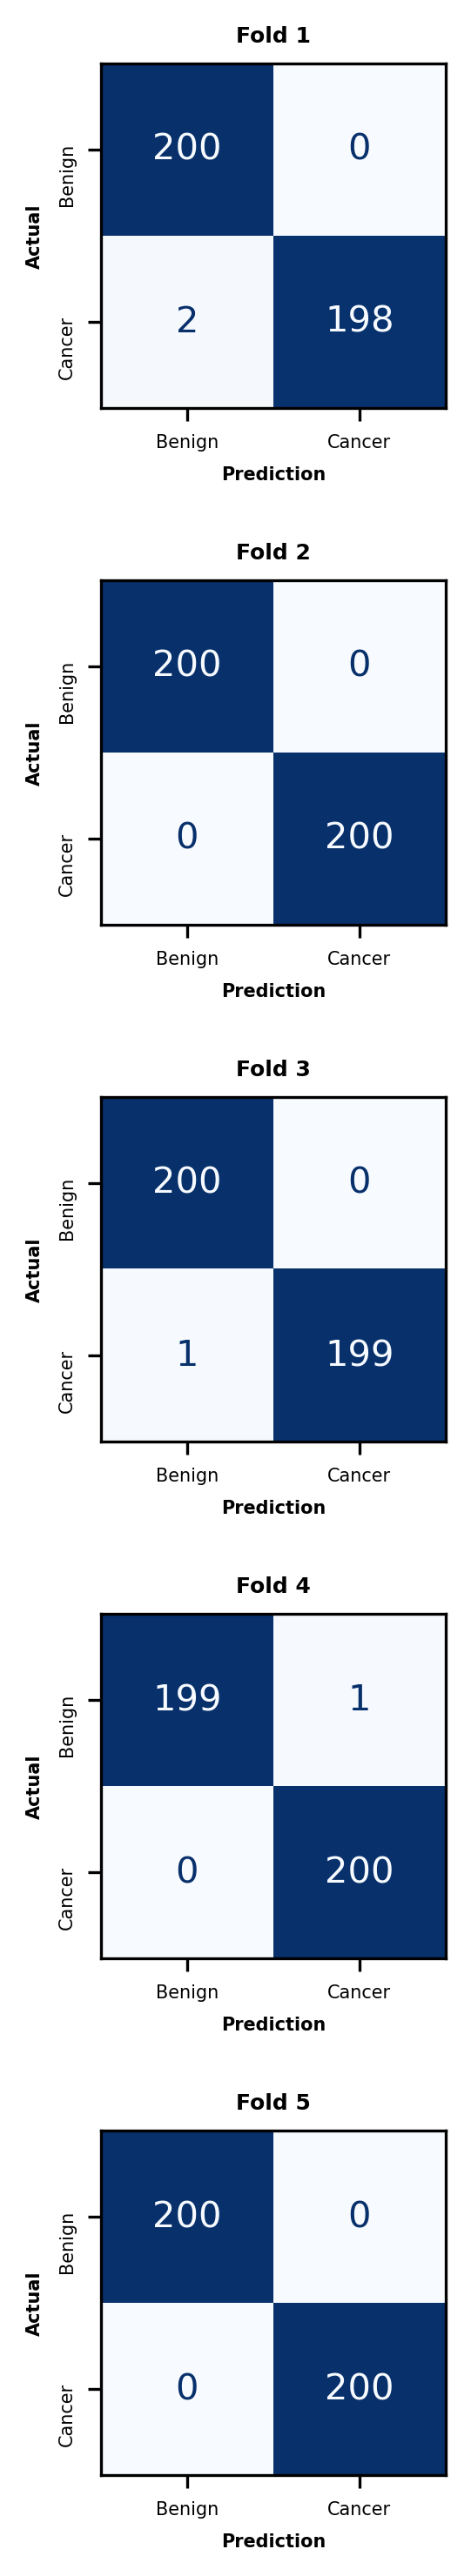

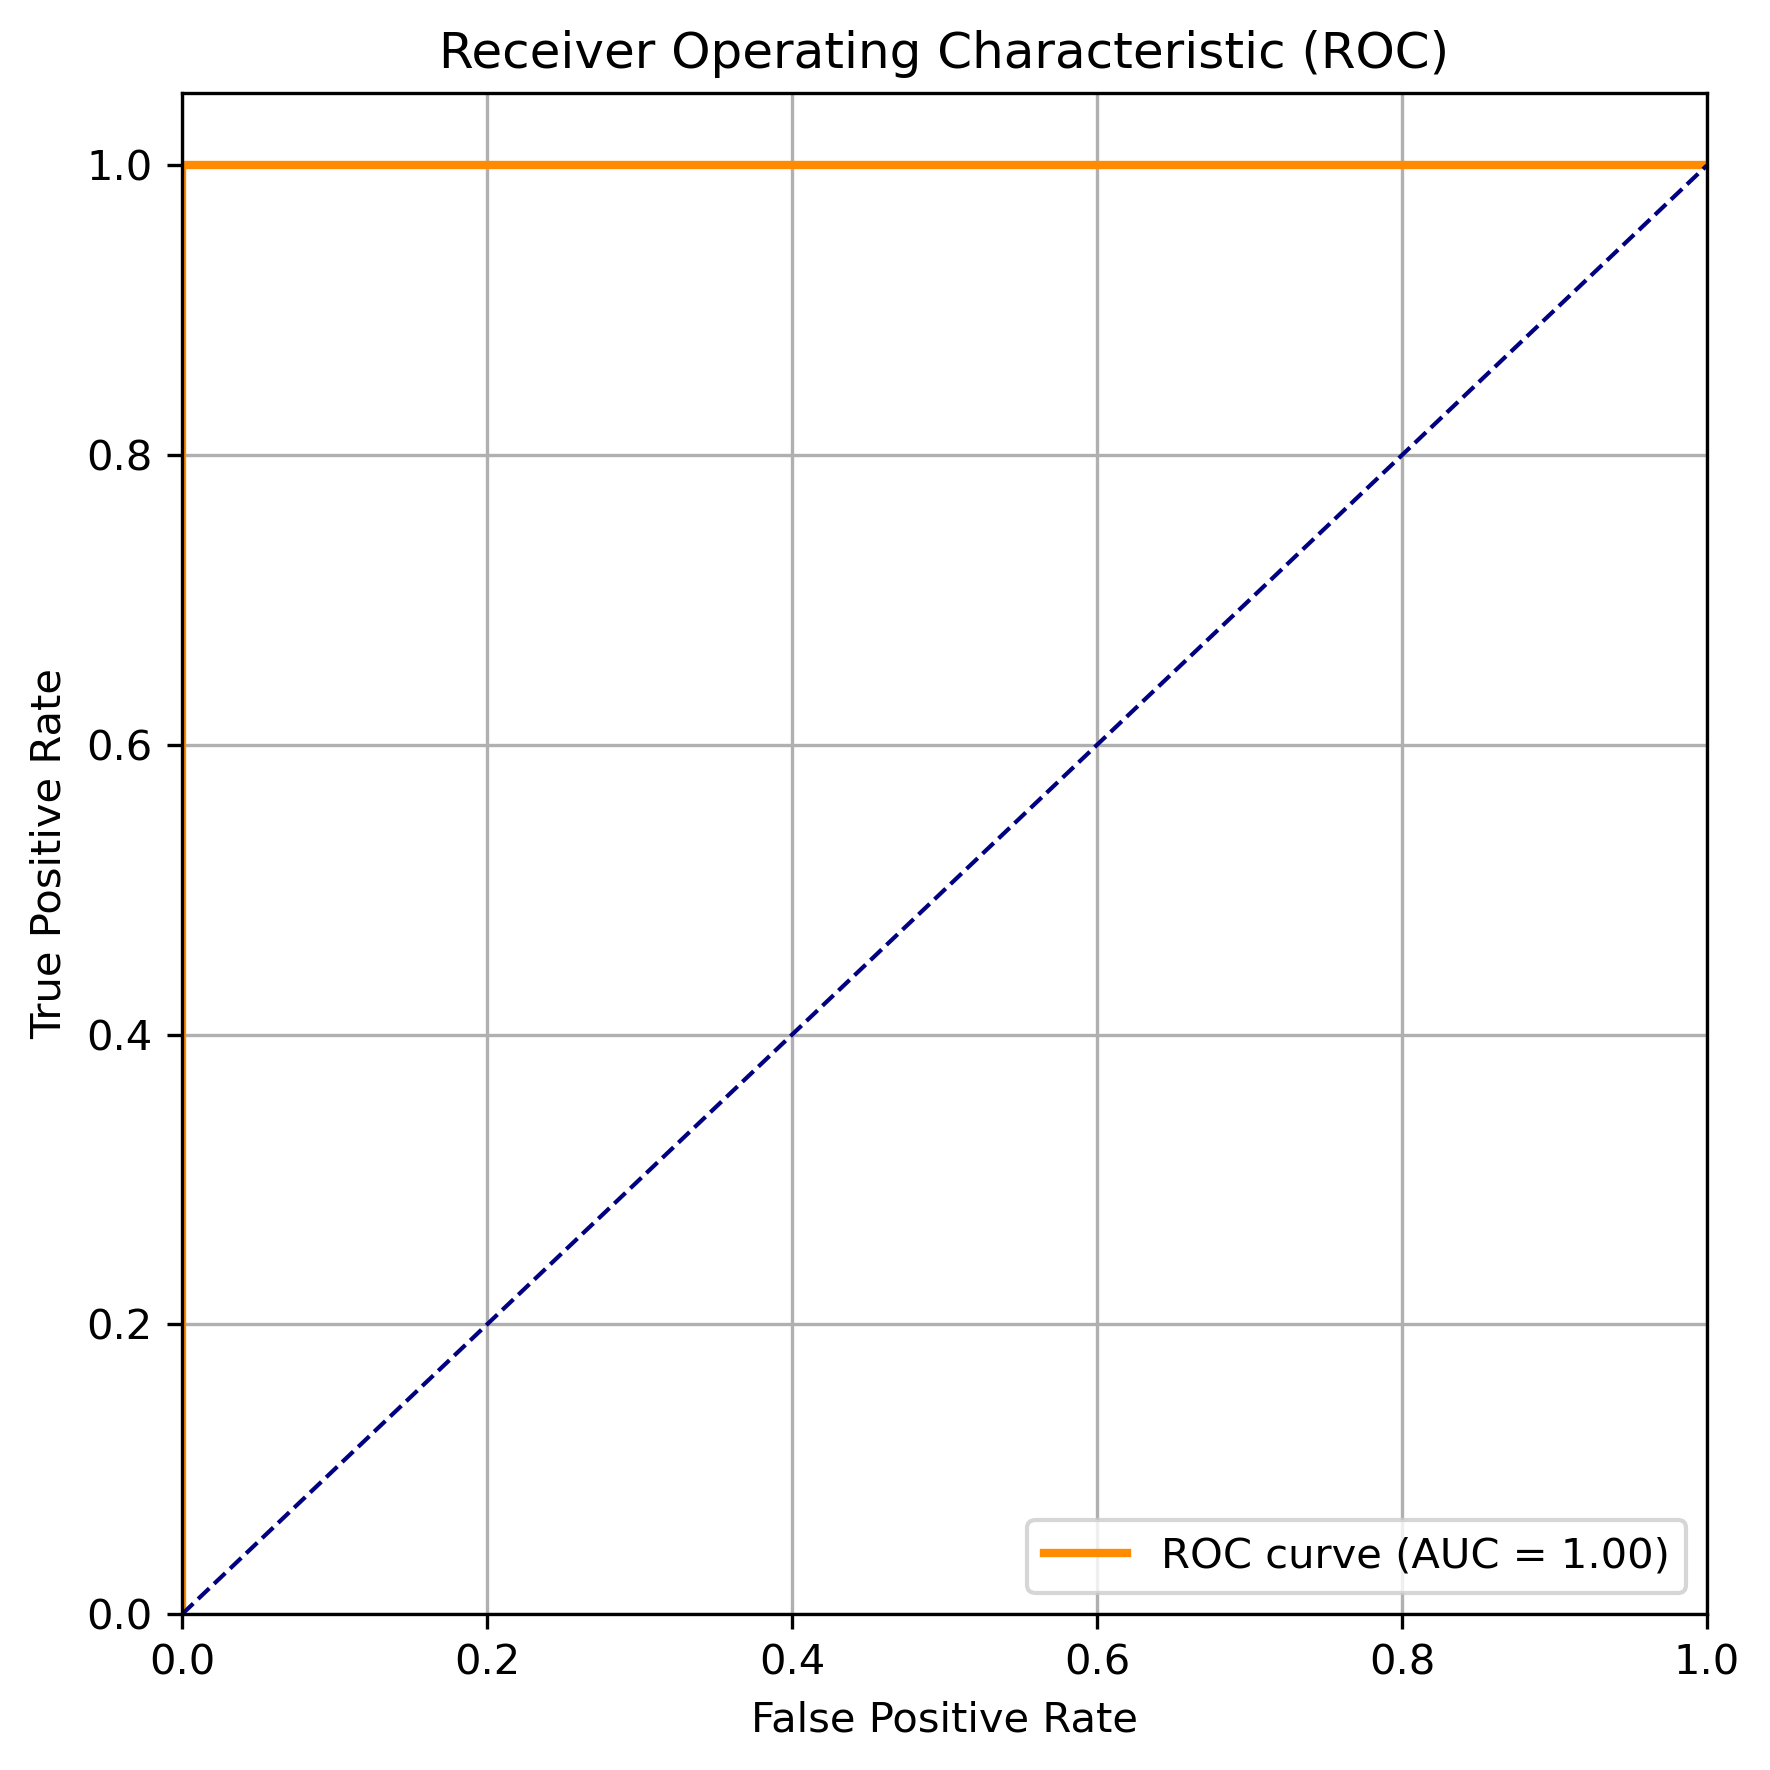

Permutation Test Results:
  Original Model Accuracy: 0.9980
  Mean Permuted Accuracy: 0.4983
  p-value: 0.0099
  The model significantly outperforms random chance (p < 0.05).


In [11]:
labels_file_path = os.path.join(PIPLINE_03_DIR, 'training_data_labels.csv')
features_file_path = os.path.join(PIPLINE_03_DIR, 'training_data_reduced_features.csv')

model_file_prefix = os.path.join(MODELS_DIR, 'p03_cv')
report_file_prefix = os.path.join(REPORTS_DIR, 'p03_cv')

cross_validate_model(features_file_path, labels_file_path, model_file_prefix, report_file_prefix,
    perm=True, num_splits=5, n_permutations=100)

---

### **Step 4: Model Evaluation on Unseen test data**




In [12]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

training_labels_file_path = os.path.join(PIPLINE_03_DIR, 'training_data_labels.csv')

training_file_path = os.path.join(PIPLINE_03_DIR, 'training_data_reduced_features.csv')

testing_file_path = os.path.join(INTERIM_DIR, 'testing_data_features.csv')
testing_file_labels_path = os.path.join(INTERIM_DIR, 'testing_data_labels.csv')

In [13]:
# === 1. Load training data ===
X_train = pd.read_csv(training_file_path, header=0)  # first row = gene names
y_train = pd.read_csv(training_labels_file_path)['label']  # reads the 'label' column

In [14]:
# === 2. Load testing data ===
X_test = pd.read_csv(testing_file_path, header=0)  # same structure
y_test = pd.read_csv(testing_file_labels_path)['label']  # again, select 'label' column

In [15]:
with open(os.path.join(PIPLINE_03_DIR,'selected_feature_names.pkl'), 'rb') as f:
    selected_feature_names = pickle.load(f)

# Select features and apply PCA on testing data 
X_test_selected = X_test[selected_feature_names]

In [16]:
with open(os.path.join(PIPLINE_03_DIR,'pca_transformer_50.pkl'), 'rb') as f:
    pca_transformer_50 = pickle.load(f)

X_test_pca = pca_transformer_50.transform(X_test_selected)

In [17]:
# === 4. Train the model ===
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [18]:
# Save final trained model
model_file_prefix = os.path.join(MODELS_DIR, 'p03_model')

with open(f"{model_file_prefix}.pkl", "wb") as model_file:
    pickle.dump(model, model_file)

In [19]:
# === 5. Predict and evaluate ===
y_pred = model.predict(X_test_pca)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [20]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

In [21]:
# Print evaluation metrics
print("Model Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Model Evaluation Metrics:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


<Figure size 1200x1200 with 0 Axes>

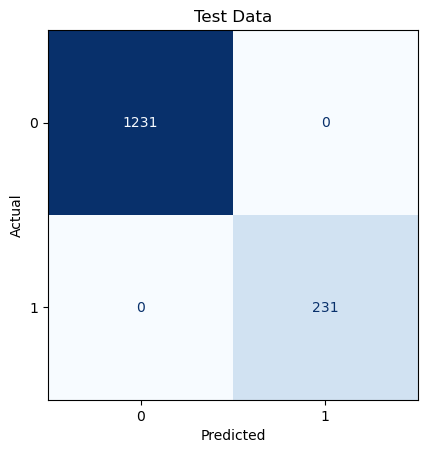

In [22]:
# Assuming 'y_test' are true labels and 'y_pred' are predicted labels
fig_cm_unseen = plt.figure(figsize=(4, 4), dpi=300, constrained_layout=False)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', colorbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title('Test Data')
plt.show()